# Ranking Artists/Bands through analysis of yearly Top 100 Songs using Wikipedia web scrapping from years 1970 to 2018 

### Participant- Pavleen Kaur

# Table of Contents
* Motivation
* Task Definition
* Input
* Output
* Data set
    * Collection
    * Metadata
* Scrapping Wikipedia 
* Data Parsing and Clean-up
  * Complexity of Data
  * Case of Missing Values
* Data Statistics and Interpretation
* Visualisation
    * Plot
    * Observations from Visualisation
    * Handling Outliers
* Feature engineering for alternate visualisation
* Conclusion
* Literature Review


 

# Motivation

Wikipedia is a big source of information on a wide range of topics including chronological details of events such as historical. Wikipedia is one of my go to source for any query on topics of interest. Finding the information particularly wikitables, a good source of data for analysis, I have chosen to utilize following concepts on the wikipedia top 100 songs list for years 1970 to 2018:
1. Web scrapping
2. Data Parsing and Data Clean-up
3. Dataframe and handling complexity of data
4. Data Visualisation
5. Feature Engineering

The initial challenge in the project has been to extrapolate the data wrangling from one wikipage in a manner consistent with ability to generalise the scrapping procedure and data handling from all pages. Secondly, the size and variety of information (e.g. links to more pages and information) presented an initial challenge to decide what data to include in data wrangling and features to be engineered. 


### Task definition
I intend to determine rank of artist(s)/bands based on their number of songs featured in the top 100 singles song list over the years of analysis (1970 to 2018) e.g. artists whose songs have been featured more than 20 times in the list.

I also intend to perform Feature engineering to determine ranks of artist(s)/bands through alternate analysis.







### Input
[Song Ranking, Song name, Artist(s)/band, URLS of Singer/Band,url of song] through web scrapping 38 pages  to extract wikitables for Top 100 songs/year from 1970 to 2018

### Output
1. Bar plot indicating ranks of artists based on number of their songs in the list 
2. Bar plot indicating scores of artists based on feature engineering


### Dataset

How data was collected?

I have performed web scrapping of wikipedia websites of Top 100 singles songs to extract wikitables. 

Why data was collected?

Data was collected to obtain a comprehensive information source containing relevant information which can be utitilzed to answer the question. Also, information structure and access to more information through wikipedia links made it a choice to add more features.



### Metadata

1. `Source`: Wikipedia e.g. https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_number-one_singles_of_1970
2. `Years` of data scrapped: 1970 to 2018 (>=100 singles/year)
3. `ranking`: rank of every song in the list e.g. 1,2,3,........upto 100
4. `band_singer`: name of artist(s)/band e.g. 'Apollo 100'
5. `song`: name of song(s) featured in the list e.g. 'Joy'
6. `songurl`: url of the song e.g. '/wiki/Foolish_Games', None
7. `url`: url of the artist(s)/band e.g. '/wiki/Apollo_100'


In [89]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

##  Scraping Wikipedia 

First, I perform scrapping of top 100 songs from Wikipedia to extract wikitable using BeautifulSoup and Python's requests library to fetch web page.

####  Parsing the Top 100 Wikipedia page for year 1970

Obtaining the web page at http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970 and extracting the top 100 singles and their rankings. I create a list of dictionaries, 100 of them, with entries like 

`{'band_singer': 'The Guess Who\n','ranking': 3, 'title': '"American Woman"', 'url': '/wiki/The_Guess_Who'}`

`{'band_singer': 'B.J. Thomas\n','ranking': 4, 'title': '"Raindrops Keep Fallin\' on My Head"','url': '/wiki/B.J._Thomas'}`

In [2]:
from bs4 import BeautifulSoup
import requests

In [3]:
# I access the webpage and download the content using requests
year1970=requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_1970")
year1970

<Response [200]>

In [7]:
# I use the request object that was previously created to create a BeautifulSoup element
soup = BeautifulSoup(year1970.text, "html.parser")

# In this line I find a single "table" element with a class of wikitable;
# and then looking for all the "tr" elements indicating the row elements on that table
rows = soup.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]

# I define a function to work upon each column's element in each row in the table
def function_on_each_column_element(r):
    ranking = int(r[0].get_text())
    title = r[1].get_text()
    band_singer = r[2].get_text()
    url = r[2].find("a").get("href")
    return [ranking, title, band_singer, url]


# I create a list of names that will be used as dictionary keys to
# save information extracted by running the above function
fields = ["ranking", "title", "band_singer", "url"]

# I use the function_on_each_column_element to work on each "td" element on a given row
# It gives band information
# The zip function creates a list of pairs further used by dict function 
# to create a dictionary, the first element of the pair is the key and the second is
# the value; and finally, the list comprehension iterates over each row element, and puts
# the result of each iteration on a list, which is then bound to the songs variable.
songs = [dict(zip(fields,function_on_each_column_element(row.find_all("td")))) for row in rows]

In [9]:
# Sample of information in songs
songs[0:5]

[{'band_singer': 'Simon & Garfunkel\n',
  'ranking': 1,
  'title': '"Bridge Over Troubled Water"',
  'url': '/wiki/Simon_%26_Garfunkel'},
 {'band_singer': 'The Carpenters\n',
  'ranking': 2,
  'title': '"(They Long to Be) Close to You"',
  'url': '/wiki/The_Carpenters'},
 {'band_singer': 'The Guess Who\n',
  'ranking': 3,
  'title': '"American Woman"',
  'url': '/wiki/The_Guess_Who'},
 {'band_singer': 'B.J. Thomas\n',
  'ranking': 4,
  'title': '"Raindrops Keep Fallin\' on My Head"',
  'url': '/wiki/B.J._Thomas'},
 {'band_singer': 'Edwin Starr\n',
  'ranking': 5,
  'title': '"War"',
  'url': '/wiki/Edwin_Starr'}]

#### Generalizing the previous scrape  for Wikipedia pages from 1970 to 2018

By visiting the urls similar to the ones mentioned previously, I obtain the top 100 songs data for all years (using range) and saving text from those requests in a dictionary called `allyears`. This dictionary has keys as the years (integers from 1970 to 2018), and  values corresponding to these keys as the text of the page being fetched.The time.sleep of one second is used is used to fetch each page.

In [10]:
#code
years=range(1970, 2019)
print(years)
allyears={}
for y in years:
    print(y)
    yreq=requests.get("http://en.wikipedia.org/wiki/Billboard_Year-End_Hot_100_singles_of_%i" % y)
    allyears[y]=yreq.text
    time.sleep(1)

range(1970, 2019)
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


#### Parsing and Data Cleaning

In code for one year i.e. 1970, a list of dictionaries, one corresponding to each single was produced. For all years' data, I write a function `parse_year(the_year, allyears_dict)` which inputs year, prints it out, gets the text for the year from the just created `allyears` dictionary, and returns a list of dictionaries for that year, with one dictionary for each single. 

The spec of Function explained

In [ ]:
"""
Function
--------
parse_year

Inputs
------
the_year: the year I want the singles for
allyears_dict: dictionary keys- integer years, values- the downloaded web pages 
    from wikipedia for that year.
   
Returns
-------

a list of dictionaries, each of which corresponds to a single and has the
following data:

Eg:

{'band_singer': ['Brandy', 'Monica'],
  'ranking': 2,
  'song': ['The Boy Is Mine'],
  'songurl': ['/wiki/The_Boy_Is_Mine_(song)'],
  'titletext': '" The Boy Is Mine "',
  'url': ['/wiki/Brandy_Norwood', '/wiki/Monica_(entertainer)']}
  
A dictionary with the following data:
    band_singer: a list of bands/singers who made this single
    song: a list of the titles of songs on this single
    songurl: a list of the same size as song which has urls for the songs on the single 
    ranking: ranking of the single
    titletext: the contents of the table cell
    band_singer: a list of bands or singers on this single
    url: a list of wikipedia singer/band urls on this single: only part 
        of the url from /wiki onwards
    


-----

"""

#### Complexity of Data

Some singles had multiple songs:

```
{'band_singer': ['Jewel'],
  'ranking': 2,
  'song': ['Foolish Games', 'You Were Meant for Me'],
  'songurl': ['/wiki/Foolish_Games',
   '/wiki/You_Were_Meant_for_Me_(Jewel_song)'],
  'titletext': '" Foolish Games " / " You Were Meant for Me "',
  'url': ['/wiki/Jewel_(singer)']}
```

### Case of missing values

Some singles did not have a song URL:

```
{'band_singer': [u'Nu Flavor'],
  'ranking': 91,
  'song': [u'Heaven'],
  'songurl': [None],
  'titletext': u'"Heaven"',
  'url': [u'/wiki/Nu_Flavor']}
```
To address this, I set songurl to [None] and the song name to the contents of the table cell with the quotes stripped (titletext stripped of its quotes)

There were more than one `band_singer`(sometimes with a comma, sometimes with "featuring" in between)
To parse these, I looked at their urls.

```
{'band_singer': ['Puff Daddy', 'Faith Evans', '112'],
  'ranking': 3,
  'song': ["I'll Be Missing You"],
  'songurl': ['/wiki/I%27ll_Be_Missing_You'],
  'titletext': '" I\'ll Be Missing You "',
  'url': ['/wiki/Sean_Combs', '/wiki/Faith_Evans', '/wiki/112_(band)']}
 ```


The `titletext` retained the quotes that Wikipedia puts on the single


All the issues mentioned above were addressed by the function below

In [17]:
# Function code

fields = ["ranking", "song", "songurl", "titletext", "band_singer", "url"]

# Helper functions.
def get_cols(row):
    return row.find_all("th") + row.find_all("td")

def break_a(col):
    return list(map(list, zip(*[(a.get("title").strip('"'), a.get("href")) for a in col.find_all("a")]))) \
            or [[col.get_text().strip('"')], [None]]
    
def parse_cols(cols):
    return [int(cols[0].get_text())] + break_a(cols[1]) + [cols[1].get_text()] + break_a(cols[2])

def create_dict(cols):
    return dict(zip(fields, cols))

# Parser function.
def parse_year(year, allyears):
    soup = BeautifulSoup(allyears[year], 'html.parser')
    rows = soup.find("table", attrs={"class": "wikitable"}).find_all("tr")[1:]
    return [create_dict(parse_cols(get_cols(row))) for row in rows]

In [26]:
#checking function
parse_year(1972, allyears)[70]

{'band_singer': ['Apollo 100'],
 'ranking': 71,
 'song': ['Joy'],
 'songurl': [None],
 'titletext': '"Joy"',
 'url': ['/wiki/Apollo_100']}

In [27]:
yearinfo = {y:parse_year(y, allyears) for y in years}

#### Saving  information scraped to a file

To avoid losing data, I created a file to save the data structure, so I can rerun from here without the need to do requests and parsing again.

In [28]:
import json

In [101]:
# Please skip this in case of continuing as above
fd = open("/tmp/yearinfo.json","w")
json.dump(yearinfo, fd)
fd.close()
del yearinfo

Reloading JSON file into the yearinfo variable

In [102]:
# Can be rerun if step above not skipped
with open("/tmp/yearinfo.json", "r") as fd:
    yearinfo = json.load(fd)

In [76]:
#yearinfo

#### Construction of a dataframe from yearly information

I now construct a dataframe `flatframe` from the `yearinfo`with each row of the frame representing a song with the properties of year, song, singer, and ranking. To construct the dataframe, I iterate over the years and the singles per year. 





In [103]:
yeardict={}
for y in yearinfo.keys():
    yearlist=yearinfo[y] # list of singles for year
    yearlist2=[]
    for singledict in yearlist:
        singers=singledict['band_singer']
        for i, singer in enumerate(singers):
            songs=singledict['song'] # one or more songs per single
            for j, song in enumerate(songs): # each singer song combination
                nd={}
                nd['band_singer'] = singer
                nd['url'] = singledict['url'][i]
                nd['song'] = song
                nd['songurl'] = singledict['songurl'][j]
                nd['ranking'] = singledict['ranking']
                yearlist2.append(nd)
    yeardict[y]=pd.DataFrame(yearlist2) # one for each year
yearspanel=pd.Panel.from_dict(yeardict, orient="minor") # dataframes in a panel
hierframe=yearspanel.to_frame() # flattening giving rise to hierarchical index
hierframe.head()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.



band_singer  ranking                                        song                                           songurl                          url
major minor                                                                                                                                                           
0     1970       Simon & Garfunkel      1.0           Bridge Over Troubled Water (song)           /wiki/Bridge_Over_Troubled_Water_(song)    /wiki/Simon_%26_Garfunkel
      1971         Three Dog Night      1.0          Joy to the World (Hoyt Axton song)          /wiki/Joy_to_the_World_(Hoyt_Axton_song)        /wiki/Three_Dog_Night
      1972           Roberta Flack      1.0         The First Time Ever I Saw Your Face         /wiki/The_First_Time_Ever_I_Saw_Your_Face          /wiki/Roberta_Flack
      1973   Tony Orlando and Dawn      1.0  Tie a Yellow Ribbon Round the Ole Oak Tree  /wiki/Tie_a_Yellow_Ribbon_Round_the_Ole_Oak_Tree  /wiki/Tony_Orlando_and_Dawn
      1974        Barbra Streisand      1.0                      The Way We Were (song)                      /wiki/The_Way_We_Were_(song)       /wiki/Barbra_Streisand

In [107]:
flatframe = hierframe.reset_index()
flatframe.head()

,major,minor,band_singer,ranking,song,songurl,url
0,0,1970,Simon & Garfunkel,1.0,Bridge Over Troubled Water (song),/wiki/Bridge_Over_Troubled_Water_(song),/wiki/Simon_%26_Garfunkel
1,0,1971,Three Dog Night,1.0,Joy to the World (Hoyt Axton song),/wiki/Joy_to_the_World_(Hoyt_Axton_song),/wiki/Three_Dog_Night
2,0,1972,Roberta Flack,1.0,The First Time Ever I Saw Your Face,/wiki/The_First_Time_Ever_I_Saw_Your_Face,/wiki/Roberta_Flack
3,0,1973,Tony Orlando and Dawn,1.0,Tie a Yellow Ribbon Round the Ole Oak Tree,/wiki/Tie_a_Yellow_Ribbon_Round_the_Ole_Oak_Tree,/wiki/Tony_Orlando_and_Dawn
4,0,1974,Barbra Streisand,1.0,The Way We Were (song),/wiki/The_Way_We_Were_(song),/wiki/Barbra_Streisand


In [108]:
# must run code above to run this chunk
flatframe = flatframe.rename(columns={'minor':'year'})
del flatframe['major']
flatframe.head()

,year,band_singer,ranking,song,songurl,url
0,1970,Simon & Garfunkel,1.0,Bridge Over Troubled Water (song),/wiki/Bridge_Over_Troubled_Water_(song),/wiki/Simon_%26_Garfunkel
1,1971,Three Dog Night,1.0,Joy to the World (Hoyt Axton song),/wiki/Joy_to_the_World_(Hoyt_Axton_song),/wiki/Three_Dog_Night
2,1972,Roberta Flack,1.0,The First Time Ever I Saw Your Face,/wiki/The_First_Time_Ever_I_Saw_Your_Face,/wiki/Roberta_Flack
3,1973,Tony Orlando and Dawn,1.0,Tie a Yellow Ribbon Round the Ole Oak Tree,/wiki/Tie_a_Yellow_Ribbon_Round_the_Ole_Oak_Tree,/wiki/Tony_Orlando_and_Dawn
4,1974,Barbra Streisand,1.0,The Way We Were (song),/wiki/The_Way_We_Were_(song),/wiki/Barbra_Streisand


In [54]:
flatframe.dtypes

year            object
band_singer     object
ranking        float64
song            object
songurl         object
url             object
dtype: object

#### Type Conversion
The year field is not integer but type object due to conversions. So I used astype to convert the year entries to int

In [19]:
flatframe.year = flatframe.year.astype(int)
flatframe.dtypes

year             int64
band_singer     object
ranking        float64
song            object
songurl         object
url             object
dtype: object

### Data Statistical Summary

In [90]:
flatframe.describe()

,ranking
count,5812.000000
mean,49.796456
std,28.776563
min,1.000000
25%,25.000000
50%,49.000000
75%,75.000000
max,100.000000


In [99]:
flatframe.song.describe()

count                     5812
unique                    4550
top       Forever (Drake song)
freq                         8
Name: song, dtype: object

In [92]:
flatframe.url.describe()

count              5812
unique             2072
top       /wiki/Rihanna
freq                 45
Name: url, dtype: object

### Statistical Summary 
1. Total number of songs: 5812
2. Total number of unique songs: 4550
2. Total number of artists/bands: 2072

### Visualization

I now create a bar chart to determine the artists/band whose songs have been featured maximum number of times on the Top 100 list from years 1970 to 2018.If a singer appeared twice in a year (for different songs), this has been counted as two appearances.

To count the total number of songs of one singer in the entire dataframe, only one unique element is available i.e. the url giving singer name. I use `value_counts` from pandas to count the urls appearing in the `flatframe` and this in turn gives the number of times a particular singer's songs have made it to the Top 100 list. 

Below is the bar chart of artists/bands who have appeared more than 25 times on Top 100 list.

### Visualization based on number of songs featured

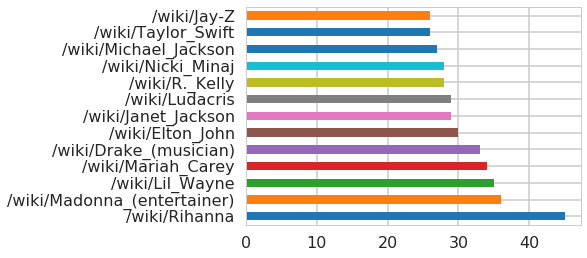

In [66]:
top_artist=flatframe.url.value_counts()
top_artist[top_artist>25].plot(kind="barh");

In [109]:
top_artist[0:10] # Top ten ranks
# artist name with total number of songs depicted as I run this cell

/wiki/Rihanna                  45
/wiki/Madonna_(entertainer)    36
/wiki/Lil_Wayne                35
/wiki/Mariah_Carey             34
/wiki/Drake_(musician)         33
/wiki/Elton_John               30
/wiki/Janet_Jackson            29
/wiki/Ludacris                 29
/wiki/R._Kelly                 28
/wiki/Nicki_Minaj              28
Name: url, dtype: int64

### Description of Data Visualised
As per the above bar chart:

1. Rihana is the top artist who has been featured 45 times
2. Madonna is on second rank who has been featured 36 times
3. Lil Wayne is on third rank with 35 songs
4. Drake is on fourth rank with 33 songs
5. Both R.Kelly and Nicki Minaj have 28 songs 

 ### Using Feature Engineering for Alternate Analysis
Both R.Kelly and Nicki Minaj have 28 songs in the Top 100 list. To determine who can be considered higher in rank of artists, I am also taking into consideration the rank of all 28 songs of each of the two singers, because the artist whose songs have gained more high ranking should be considered the better artist based on this analysis.

To do this, I group all of one singer's songs together and assign each song a score 101 - ranking (using the ranking from flatframe) to create a feature called `scores` and then order the singers by their total score and make a bar chart for the top 10 ranks based on scores

### Visualisation based on ranking of songs featured

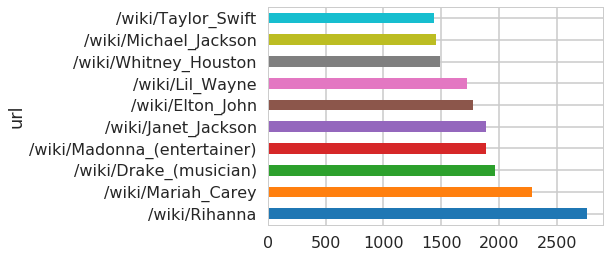

In [110]:
scores = flatframe.groupby('url').apply(lambda v: np.sum(101 - v['ranking']))
scores= scores.sort_values(ascending=False)
scores[:10].plot(kind="barh");

In [112]:
scores[0:30]
#Depicts name of the artist and total score calculated by summing individual score of each song

url
/wiki/Rihanna                  2760.0
/wiki/Mariah_Carey             2290.0
/wiki/Drake_(musician)         1969.0
/wiki/Madonna_(entertainer)    1888.0
/wiki/Janet_Jackson            1886.0
/wiki/Elton_John               1775.0
/wiki/Lil_Wayne                1723.0
/wiki/Whitney_Houston          1491.0
/wiki/Michael_Jackson          1453.0
/wiki/Taylor_Swift             1438.0
/wiki/Ludacris                 1429.0
/wiki/Jay-Z                    1417.0
/wiki/Maroon_5                 1353.0
/wiki/Justin_Timberlake        1351.0
/wiki/Bruno_Mars               1342.0
/wiki/Nicki_Minaj              1337.0
/wiki/Kanye_West               1322.0
/wiki/Katy_Perry               1319.0
/wiki/Pink_(singer)            1226.0
/wiki/Chris_Brown              1150.0
/wiki/Nelly                    1134.0
/wiki/Stevie_Wonder            1131.0
/wiki/Justin_Bieber            1106.0
/wiki/Akon                     1086.0
/wiki/Sean_Combs               1068.0
/wiki/R._Kelly                 1023.0
/wiki/Al

### Description of Data Visualised
As per the above bar chart for alternate analysis:

1. Rihanna is still the top artist whose songs generate a total score of 2760
2. Maria Carie is on second rank contrary to Madonna in first visualisation as she has a score of 2290 despite having only 34 songs
3. Nicki Minaj ranks way ahead of R.Kelly 


### Outliers

The analysis being such that rankings are to be generated, offer no scope of using outliers concept as entire data is needed to be considered.

### Conclusion

Based on different metrics, we receive different ranking for artists. However, under both analysis, Rihanna is the top artist. The project offered scope to utilize all skills of EDA and include many other features and complexity as more and more data could be incorporated from url links and vastness of Wikipedia content such as Age of Artists.

### Literature Review

Wikipedia is often used for various kinds of analysis and interesting studies conducted for professional reading content generators such as Business Insider and other magazines. The novelty of this project lies in the question based on different metrics and that this project can be used continuously every year to determine the rankings of artists or bands by incorporating data of coming years as it is made available on Wikipedia.